In [1]:
from dateutil.relativedelta import *
from dateutil.easter import *
from dateutil.rrule import *
from dateutil.parser import *
from datetime import *
from sklearn.preprocessing import LabelEncoder

import conf
from UI.LOG import *
import cv2
from aml.train_pipeline import *  
from aml.train_pipeline import *
import pandas as pd

import os
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor,FasterRCNN_ResNet50_FPN_Weights
from torchinfo import summary

# from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead,SSD300_VGG16_Weights,det_utils
from torchvision.models.detection import ssd300_vgg16

import torch

import aml.model_using as model_using
import aml.support_func as support_funcS
import aml.time_mesuarment as time_mesuarment
import sys

import aml.managers as managers
import aml.img_processing as img_processing
import random
import numpy as np
import pprint
from torchinfo import summary
from aml.img_processing import *

from PIL import Image
import aml.models as models
import matplotlib.pyplot as plt
from pprint import pprint as Print
from PIL import Image
import warnings
from torchvision.utils import draw_bounding_boxes  
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms 
from torchmetrics.detection.mean_ap import MeanAveragePrecision as mAP
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from IPython.display import IFrame, display, HTML
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from data_manip import cat_features_
import catboost
from io import StringIO 
import sys
from sklearn.metrics import roc_auc_score
from catboost import utils
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from tqdm import tqdm
tqdm.pandas()

def simple_plot(x,y,title=''):
    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.plot(x,y)
    ax.set_title(title)
    return fig,ax
def Gini(fpr,tpr):
    return 2*metrics.auc(fpr,tpr)-1
def plot_gxb_train_results(results):
    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.plot(results['train-auc-mean'],label= 'train-auc-mean')
    ax.plot(results['test-auc-mean'],label= 'test-auc-mean')
    ax.legend()
    return fig,ax

    

In [2]:
X = pd.read_csv(conf.X_train_dataset,index_col=False)
Y = pd.read_csv(conf.Y_train_dataset,index_col=False)

In [3]:
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, train_size=0.8, random_state=1234)
features_names = [el for el in X]
cat_features = np.setdiff1d(cat_features_,np.setdiff1d(cat_features_,features_names))

In [4]:
dtrain_ = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dval_ = xgb.DMatrix(X_validation, y_validation, enable_categorical=True)
all_train_ = xgb.DMatrix(X,Y,enable_categorical=True)

In [5]:
# def gen_random(mid_point,low_mul,high_mul,dtype,N_):
#     a_ = mid_point*low_mul
#     b_ = mid_point*high_mul
#     values = np.random.uniform(low=a_,high=b_,size = N_)
#     if dtype == 'int':
#         return np.array(values,dtype=np.int64)
#     if dtype == 'float':
#         return values

# def make_random_grid_search():
#     mid = {
#         'eta': 0.05,
#         'subsample': 0.2,
#         'max_depth': 6,
#         'learning_rate': 0.05,
#         'n_estimators': 2000,
#         'gamma':  0.1,
#         'subsample': 0.5,
#         'colsample_bytree':0.5, 
#         'colsample_bylevel':0.5, 
#         'colsample_bynode':0.5,
#         'lambda': 1.5,
#         'alpha': 0.1,
#         'scale_pos_weight': np.sum(np.where(Y==0))/np.sum(np.where(Y==1)),
#         'min_child_weight': 5,
#         'max_delta_step': 5,
#     }

#     N = 3
#     grid = pd.DataFrame({
#         'eta':                  gen_random(mid['eta'], 0.5, 2.0,'float',N),
#         'subsample':            gen_random(mid['subsample'], 0.5, 2.0,'float',N),
#         'max_depth':            gen_random(mid['max_depth'], 0.5, 2.0,'float',N),
#         'alpha'                 gen_random(mid['alpha'], 0.5, 2.0,'float',N): ,
#         'learning_rate':        gen_random(mid['learning_rate'], 0.5, 2.0,'float',N),
#         'n_estimators':         gen_random(mid['n_estimators'], 0.5, 2.0,'float',N),
#         'colsample_bytree':     gen_random(mid['colsample_bytree'], 0.5, 2.0,'float',N),
#         'gamma':                gen_random(mid['gamma'], 0.5, 2.0,'float',N): , 
#         'subsample'             gen_random(mid['subsample'], 0.5, 2.0,'float',N): ,
#         'colsample_bytree'      gen_random(mid['colsample_bytree'], 0.5, 2.0,'float',N): ,
#         'min_child_weight':     gen_random(mid['min_child_weight'], 0.5, 2.0,'float',N),
#         'max_delta_step':       gen_random(mid['max_delta_step'], 0.5, 2.0,'float',N),
#     })
#     return grid

# def fit(x):
#     params = {
#               'objective':'binary:logistic',
#               'eval_metric':'auc',
#               'eta':x[0],
#               'subsample':x[1],
#               }
#     xgb_cv = xgb.cv(dtrain=all_train_, params=params, nfold=5, metrics = 'logloss',seed=42,num_boost_round=10,early_stopping_rounds=5)
#     return xgb_cv[-1:].values[0]
# grid = make_random_grid_search()
# grid[['train-logloss-mean','train-logloss-std','test-logloss-mean','test-logloss-std']] = grid.progress_apply(fit, axis=1, result_type='expand')
# grid



In [6]:
eval_metric = 'auc'

params = {
    'eta': 0.05,
    'subsample': 0.0,
    'max_depth': 6,
    'learning_rate': 0.05,
    'n_estimators': 3000,
    'gamma':  0.1,
    'subsample': 0.5,
    'colsample_bytree':0.5, 
    'colsample_bylevel':0.5, 
    'colsample_bynode':0.5,
    'lambda': 1.5,
    'alpha': 0.1,
    'scale_pos_weight': np.sum(np.where(Y==0))/np.sum(np.where(Y==1)),
    'min_child_weight': 5,
    'max_delta_step': 5,
    'objective':'binary:logistic',
    'eval_metric': eval_metric, 
    'tree_method':'gpu_hist',
    'gpu_id':0,
    'seed':0
}    

model = XGBClassifier(**params)

In [7]:
model.fit(X,Y, eval_set=[(X_train, y_train), (X_validation, y_validation)],verbose=True)


[18:05:40] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


XGBoostError: [18:05:40] ../src/gbm/gbtree.cc:625: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /home/user/python3venvs/ml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2a7e13) [0x7f2627ea7e13]
  [bt] (1) /home/user/python3venvs/ml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2ab120) [0x7f2627eab120]
  [bt] (2) /home/user/python3venvs/ml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2ab52a) [0x7f2627eab52a]
  [bt] (3) /home/user/python3venvs/ml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2e03c7) [0x7f2627ee03c7]
  [bt] (4) /home/user/python3venvs/ml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f2627d3c5a0]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2741834e2e]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2741831493]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f27418443e9]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x9a00) [0x7f2741843a00]



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

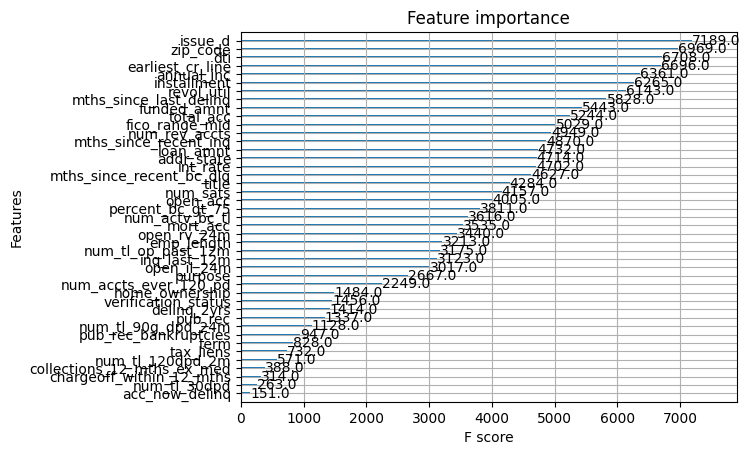

In [8]:
xgb.plot_importance(model)

AUC 0.7771618632896828
Gini 0.5543237265793657


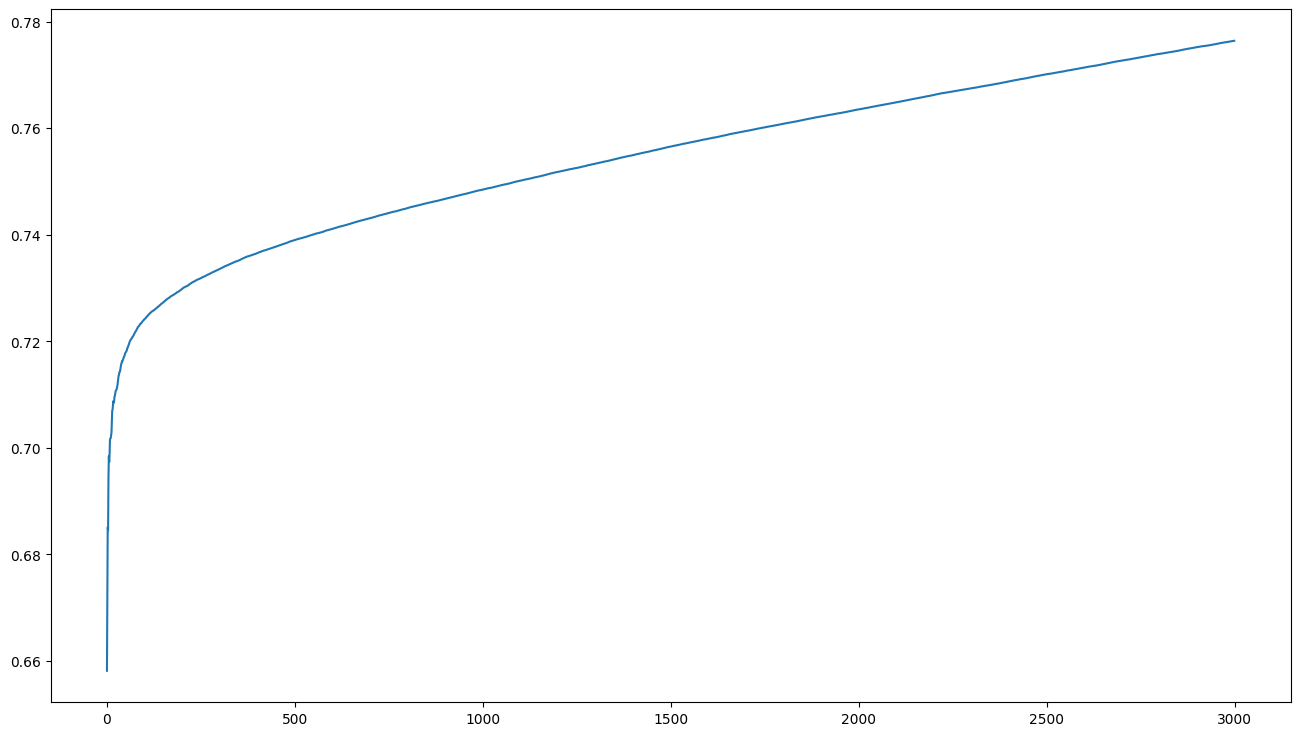

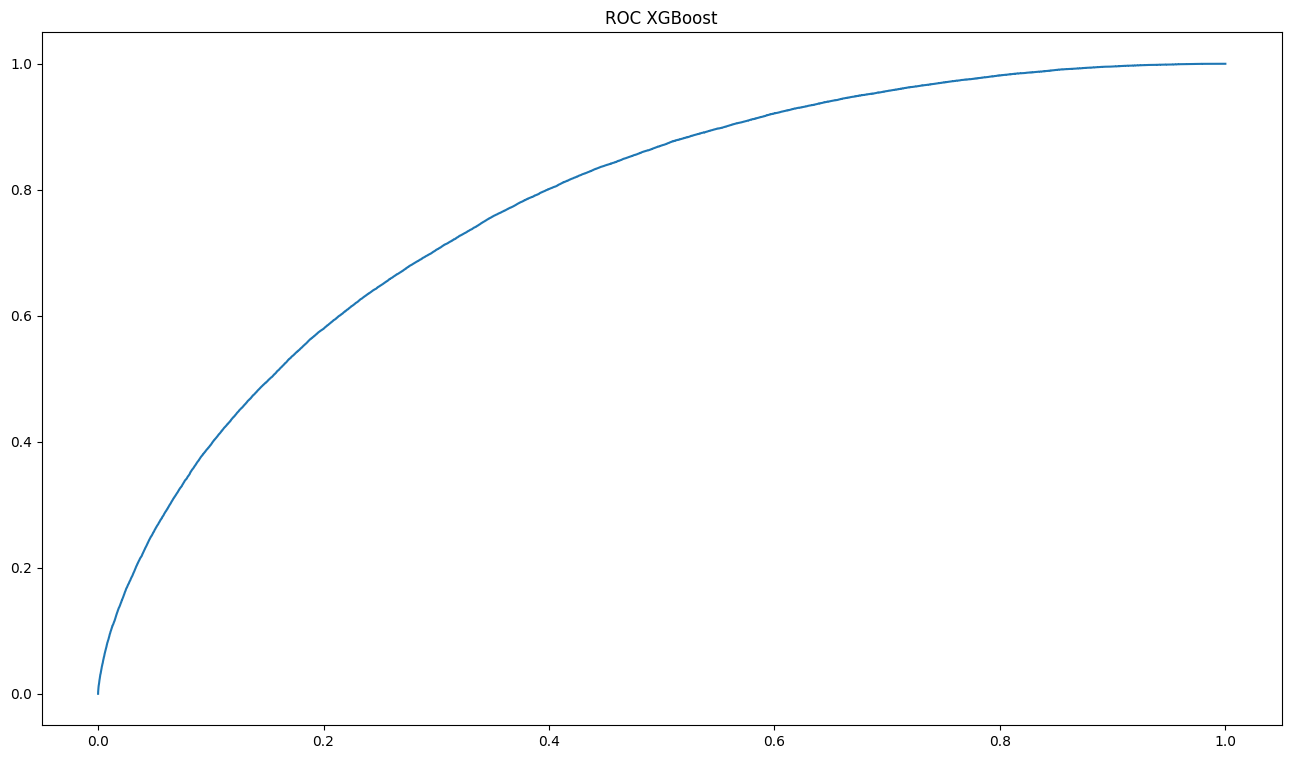

In [9]:
results = model.evals_result()
auc_vec = results['validation_0'][eval_metric]
simple_plot(np.arange(0,len(auc_vec)), auc_vec)
preds_ = model.predict(X_validation)
probas_ = model.predict_proba(X_validation)
fpr,tpr,tr = metrics.roc_curve(y_validation,probas_[:,1],pos_label=1)
simple_plot(fpr,tpr,title='ROC XGBoost')
print('AUC {}'.format(metrics.auc(fpr,tpr)))
print('Gini {}'.format(Gini(fpr,tpr)))

In [10]:
X_eval = pd.read_csv(conf.X_test_dataset,index_col=False)

In [11]:
eval_preds_ = model.predict(X_eval)
eval_proba_ = model.predict_proba(X_eval)

In [12]:
probability_of_positive_class = eval_proba_[:,1]
probability_of_negative_class = eval_proba_[:,0]

(0.0, 1.0)

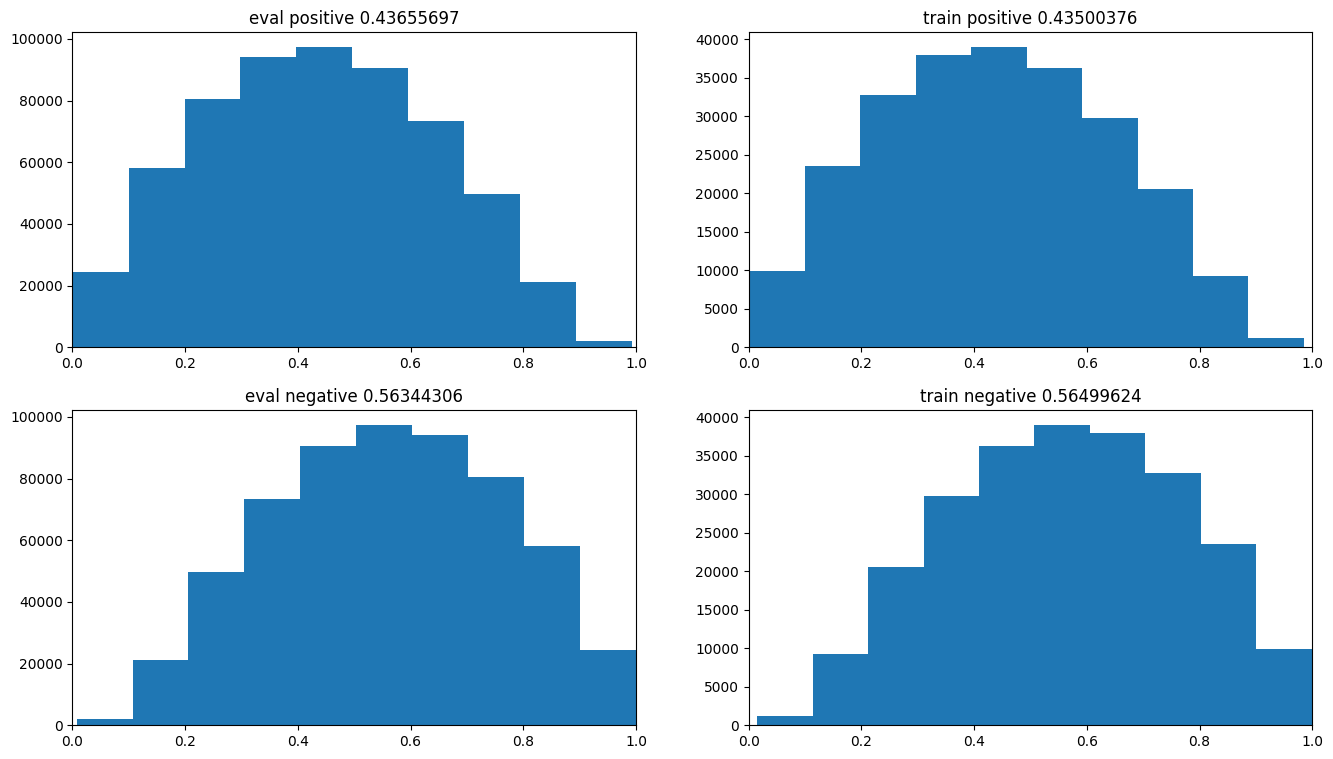

In [13]:
fig1,ax1 = plt.subplots(2,2)
fig1.set_size_inches(16,9)
ax1[0][0].hist(probability_of_positive_class)
ax1[0][0].set_xlim([0.0,1.0])
ax1[0][0].set_title('eval positive '+str(np.median(probability_of_positive_class)))
ax1[1][0].hist(probability_of_negative_class)
ax1[1][0].set_title('eval negative '+str(np.median(probability_of_negative_class)))
ax1[1][0].set_xlim([0.0,1.0])

validation_posive_distrib = probas_[:,1]
validation_negative_distrib = probas_[:,0]
ax1[0][1].hist(validation_posive_distrib)
ax1[0][1].set_xlim([0.0,1.0])
ax1[0][1].set_title('train positive '+str(np.median(validation_posive_distrib)))
ax1[1][1].hist(validation_negative_distrib)
ax1[1][1].set_title('train negative '+str(np.median(validation_negative_distrib)))
ax1[1][1].set_xlim([0.0,1.0])




In [25]:
def make_submission(positive_probabilities):
    d = {'index': [i for i in range(0,len(positive_probabilities))], 'loan_status': positive_probabilities}
    o_df = pd.DataFrame(data=d)
    submission_csv = os.path.join('answer.csv')
    submission_zip = os.path.join(conf.data_folder,'answer.zip')
    o_df.to_csv(submission_csv,index=False)
    os.system('rm {}'.format(submission_zip))
    os.system('zip {} {}'.format(submission_zip, submission_csv))

In [26]:
make_submission(positive_probabilities=probability_of_positive_class)

  adding: answer.csv (deflated 61%)


: 